In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import os
import argparse
from pathlib import Path
import re
import random
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Normalization across the whole dataset

In [ ]:
from pathlib import Path
import re, random, math, os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# =========================
# Config
# =========================
SPLIT_DIR = r"/content/drive/MyDrive/CD/patient_data_clean_1800s_nozero_3c_1000"
POS_PATIENTS = {1, 2, 16, 19, 21, 22, 25, 37, 39, 43, 44, 47, 50, 56, 58, 62, 65, 66, 73, 78}

BATCH_SIZE       = 32
EPOCHS           = 100
LR               = 1e-4
SEED             = 1337
BEST_MODEL_PATH  = "best_keras_img_by_val_acc.h5"

# Your segments are 1800 rows tall
TARGET_H = 1800

# =========================
# Repro
# =========================
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
for g in tf.config.list_physical_devices('GPU'):
    try: tf.config.experimental.set_memory_growth(g, True)
    except Exception: pass

# =========================
# Helpers for ID/labels
# =========================
PATIENT_NUM_RX = re.compile(r'^ID(\d+)')       # e.g., "ID76-2_..." -> 76
BASE_ID_RX     = re.compile(r'^(ID\d+(?:-\d+)?)')

def patient_num_from_path(pathlike):
    stem = Path(pathlike).stem
    m = PATIENT_NUM_RX.match(stem)
    return int(m.group(1)) if m else None

def base_id_from_path(pathlike):
    stem = Path(pathlike).stem
    m = BASE_ID_RX.match(stem)
    return m.group(1) if m else stem

def label_for_file(p: Path) -> int:
    pnum = patient_num_from_path(p)
    return 1 if (pnum is not None and pnum in POS_PATIENTS) else 0

# =========================
# List files & make ID-based splits (80/10/10 by ID)
# =========================
split_dir = Path(SPLIT_DIR)
all_csvs = sorted(split_dir.glob("*.csv"))
if not all_csvs:
    raise FileNotFoundError(f"No CSV found in {SPLIT_DIR}")

# Map: id -> list of files for that patient
id_to_files = {}
for f in all_csvs:
    pid = patient_num_from_path(f)
    if pid is None:
        continue
    id_to_files.setdefault(pid, []).append(f)

all_ids = sorted(id_to_files.keys())
print('all_ids = ', all_ids)

# Stratify by label at ID level
id_labels = np.array([1 if pid in POS_PATIENTS else 0 for pid in all_ids], dtype=int)

ids_trainval, ids_test = train_test_split(
    all_ids, test_size=0.10, random_state=SEED, stratify=id_labels
)
labels_trainval = np.array([1 if pid in POS_PATIENTS else 0 for pid in ids_trainval], dtype=int)

ids_train, ids_val = train_test_split(
    ids_trainval, test_size=0.1111111, random_state=SEED, stratify=labels_trainval
)

train_files = [f for pid in ids_train for f in id_to_files[pid]]
val_files   = [f for pid in ids_val   for f in id_to_files[pid]]
test_files  = [f for pid in ids_test  for f in id_to_files[pid]]

def split_summary_by_ids(name, ids, files):
    ys = np.array([label_for_file(f) for f in files], dtype=int)
    print(f"{name:>6} | ids: {len(ids):4d} | files: {len(files):5d} | pos files: {(ys==1).sum():4d} | neg files: {(ys==0).sum():4d}")

print("\n--- ID-based split summary ---")
split_summary_by_ids("train", ids_train, train_files)
split_summary_by_ids("val",   ids_val,   val_files)
split_summary_by_ids("test",  ids_test,  test_files)
print("------------------------------\n")

# =========================
# Image loader (drop Time; keep ALL other columns)
# =========================
def _drop_time_cols(df: pd.DataFrame) -> pd.DataFrame:
    # remove any column named "Time" (case-insensitive, trimmed)
    time_like = [c for c in df.columns if isinstance(c, str) and c.strip().lower() == "time"]
    return df.drop(columns=time_like, errors="ignore")

def _to_numeric_df(df: pd.DataFrame) -> pd.DataFrame:
    # Drop Time; coerce others to numeric (non-numeric → NaN → 0.0)
    df = _drop_time_cols(df)
    return df.apply(pd.to_numeric, errors="coerce").fillna(0.0)

def _pad_crop_2d(x: np.ndarray, H: int, W: int) -> np.ndarray:
    h, w = x.shape
    if h < H:
        pad = np.zeros((H, w), dtype=x.dtype); pad[:h, :] = x; x = pad; h = H
    elif h > H:
        x = x[:H, :]; h = H
    if w < W:
        pad = np.zeros((h, W), dtype=x.dtype); pad[:, :w] = x; x = pad
    elif w > W:
        x = x[:, :W]
    return x

def _infer_target_width(example_csv: Path) -> int:
    df = pd.read_csv(example_csv)
    df2 = _to_numeric_df(df)              # KEEP all non-Time columns
    return df2.shape[1]                   # width = number of non-Time columns

if not len(train_files):
    raise RuntimeError("Empty training split after ID-based split; check your data/IDs.")
TARGET_W = _infer_target_width(train_files[0])
print(f"TARGET_H={TARGET_H}, TARGET_W={TARGET_W}")

def load_csv_as_image_raw(csv_path: Path) -> np.ndarray:
    """Load CSV → drop Time → numeric → pad/crop → [H,W,1] float32. NO normalization."""
    df = pd.read_csv(csv_path)
    df2 = _to_numeric_df(df)              # Time removed here
    mat = df2.to_numpy(dtype=np.float32)  # [rows, cols]
    mat = _pad_crop_2d(mat, TARGET_H, TARGET_W)
    img = mat[:, :, None]                 # [H, W, 1]
    return img.astype(np.float32)

# Tiny cache (raw)
CACHE_RAW = {}
def load_csv_as_image_raw_cached(csv_path: Path) -> np.ndarray:
    key = ("raw", str(csv_path))
    if key in CACHE_RAW:
        return CACHE_RAW[key]
    img = load_csv_as_image_raw(csv_path)
    CACHE_RAW[key] = img
    return img

# =========================
# Compute ONE global mean/std over WHOLE DATASET (train+val+test)
# =========================
def compute_global_mean_std(files) -> tuple[float, float]:
    s_sum, s_sqsum, n = 0.0, 0.0, 0
    for f in files:
        x = load_csv_as_image_raw_cached(f).astype(np.float64)  # [H, W, 1]
        s_sum   += x.sum()
        s_sqsum += (x * x).sum()
        n       += x.size
    mean = s_sum / n
    var  = max(1e-12, s_sqsum / n - mean**2)
    std  = np.sqrt(var)
    return float(mean), float(std)

GLOBAL_MEAN, GLOBAL_STD = compute_global_mean_std(all_csvs)
print(f"Global z-score stats (ALL files, non-Time cols): mean={GLOBAL_MEAN:.6f}, std={GLOBAL_STD:.6f}")

def apply_global_zscore(img: np.ndarray) -> np.ndarray:
    return ((img - GLOBAL_MEAN) / (GLOBAL_STD + 1e-8)).astype(np.float32)

# =========================
# Keras Sequence (uses GLOBAL z-score)
# =========================
class ImageSequence(keras.utils.Sequence):
    def __init__(self, files, batch_size=BATCH_SIZE, shuffle=True):
        super().__init__()
        self.files = list(files)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.files) / self.batch_size)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.files))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        idxs = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_files = [self.files[i] for i in idxs]
        X_list, y_list = [], []
        for f in batch_files:
            x = load_csv_as_image_raw_cached(f)  # raw [H, W, 1] (Time dropped)
            x = apply_global_zscore(x)           # GLOBAL z-score
            X_list.append(x)
            y_list.append(label_for_file(f))
        return np.stack(X_list, 0), np.array(y_list, dtype=np.int32)

# =========================
# DenseNet-style 2D CNN (binary head)
# =========================
def build_model(h=TARGET_H, w=TARGET_W, c=1, lr=LR,
                growth_rate=8, block_layers=(4, 6, 6, 6),
                compression=0.5, dropout=0.2):

    inputs = keras.Input(shape=(h, w, c))

    def bn_relu_conv(x, filters, ksize, stride=1):
        #x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, ksize, strides=stride, padding="same", use_bias=False)(x)
        return x

    def dense_layer(x):
        y = bn_relu_conv(x, 4 * growth_rate, 1)
        y = bn_relu_conv(y, growth_rate, 3)
        return layers.Concatenate()([x, y])

    def dense_block(x, L):
        for _ in range(L):
            x = dense_layer(x)
        return x

    def transition_layer(x):
        filters = max(8, int(int(x.shape[-1]) * compression))
        x = bn_relu_conv(x, filters, 1)
        return layers.AveragePooling2D(pool_size=(2, 2), strides=2, padding="same")(x)

    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    for i, L in enumerate(block_layers):
        x = dense_block(x, L)
        if i != len(block_layers) - 1:
            x = transition_layer(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[keras.metrics.BinaryAccuracy(name="acc"), keras.metrics.AUC(name="auc")],
    )
    return model

# =========================
# Data generators
# =========================
train_gen = ImageSequence(train_files, batch_size=BATCH_SIZE, shuffle=True)
val_gen   = ImageSequence(val_files,   batch_size=BATCH_SIZE, shuffle=False)

# Optional: print which columns are being used (from one file)
try:
    tmp_df = pd.read_csv(train_files[0])
    used_cols = [c for c in tmp_df.columns if not (isinstance(c, str) and c.strip().lower()=="time")]
    print("Using columns (excluding Time):", used_cols)
except Exception as _e:
    pass

# =========================
# Train (save BEST by **validation accuracy**)
# =========================
model = build_model()
ckpt = keras.callbacks.ModelCheckpoint(
    BEST_MODEL_PATH, monitor="val_loss", mode="min", save_best_only=True, verbose=1
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[ckpt],        # optional: add EarlyStopping if desired
    verbose=1,
)

# =========================
# LOAD the BEST model and TEST (held-out IDs)
# =========================
best_model = keras.models.load_model(BEST_MODEL_PATH)

X_test = np.stack([apply_global_zscore(load_csv_as_image_raw_cached(f)) for f in test_files], axis=0)
y_true = np.array([label_for_file(f) for f in test_files], dtype=int)
probs1 = best_model.predict(X_test, verbose=0).ravel().astype(float)
y_pred = (probs1 >= 0.5).astype(int)

try:
    auc = roc_auc_score(y_true, probs1)
except ValueError:
    auc = float('nan')
acc = accuracy_score(y_true, y_pred)
print(f"\nEVALUATED MODEL: {BEST_MODEL_PATH} (selected by best VAL accuracy)")
print(f"Global z-score (non-Time cols): mean={GLOBAL_MEAN:.6f}, std={GLOBAL_STD:.6f}")
print(f"Image shape used: H={TARGET_H}, W={TARGET_W}, C=1")
print(f"Test acc {acc:.3f}, AUC {auc:.3f}")
print("\nConfusion matrix (test):\n", confusion_matrix(y_true, y_pred))
print("\nClassification report (test):\n", classification_report(y_true, y_pred, digits=3))

all_ids =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 33, 34, 35, 36, 37, 38, 39, 43, 44, 45, 47, 49, 50, 51, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 71, 72, 76, 78]

--- ID-based split summary ---
 train | ids:   48 | files:  6148 | pos files: 2169 | neg files: 3979
   val | ids:    6 | files:   725 | pos files:  210 | neg files:  515
  test | ids:    6 | files:   631 | pos files:  305 | neg files:  326
------------------------------

TARGET_H=1800, TARGET_W=3
Global z-score stats (ALL files, non-Time cols): mean=2.266192, std=32.439572
Using columns (excluding Time): ['Delta total FFT, 1 - 4 Hz, All 1020 No FP', 'Theta total FFT, 4 - 8 Hz, All 1020 No FP', 'Alpha total FFT, 8 - 13 Hz, All 1020 No FP']
Epoch 1/100
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - acc: 0.6385 - auc: 0.4789 - loss: 0.6725
Epoch 1: val_loss improved from inf to 0.67662, saving model to best_keras_img_by_val_acc.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 54s 146ms/step - acc: 0.6386 - auc: 0.4794 - loss: 0.6723 - val_acc: 0.7103 - val_auc: 0.2229 - val_loss: 0.6766
Epoch 2/100
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.6699 - auc: 0.5927 - loss: 0.6325
Epoch 2: val_loss improved from 0.67662 to 0.66812, saving model to best_keras_img_by_val_acc.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - acc: 0.6699 - auc: 0.5928 - loss: 0.6325 - val_acc: 0.7103 - val_auc: 0.2343 - val_loss: 0.6681
Epoch 3/100
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.6657 - auc: 0.6426 - loss: 0.6179
Epoch 3: val_loss improved from 0.66812 to 0.66609, saving model to best_keras_img_by_val_acc.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - acc: 0.6658 - auc: 0.6428 - loss: 0.6178 - val_acc: 0.7007 - val_auc: 0.3272 - val_loss: 0.6661
Epoch 4/100
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.7031 - auc: 0.7232 - loss: 0.5699
Epoch 4: val_loss improved from 0.66609 to 0.63586, saving model to best_keras_img_by_val_acc.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - acc: 0.7031 - auc: 0.7233 - loss: 0.5699 - val_acc: 0.7076 - val_auc: 0.5032 - val_loss: 0.6359
Epoch 5/100
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.7004 - auc: 0.7481 - loss: 0.5466
Epoch 5: val_loss improved from 0.63586 to 0.62682, saving model to best_keras_img_by_val_acc.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - acc: 0.7004 - auc: 0.7481 - loss: 0.5465 - val_acc: 0.6786 - val_auc: 0.5343 - val_loss: 0.6268
Epoch 6/100
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.7167 - auc: 0.7686 - loss: 0.5256
Epoch 6: val_loss improved from 0.62682 to 0.60655, saving model to best_keras_img_by_val_acc.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - acc: 0.7168 - auc: 0.7688 - loss: 0.5255 - val_acc: 0.7103 - val_auc: 0.4772 - val_loss: 0.6065
Epoch 7/100
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.7156 - auc: 0.7826 - loss: 0.5201
Epoch 7: val_loss improved from 0.60655 to 0.60296, saving model to best_keras_img_by_val_acc.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - acc: 0.7158 - auc: 0.7828 - loss: 0.5199 - val_acc: 0.7090 - val_auc: 0.5473 - val_loss: 0.6030
Epoch 8/100
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.7270 - auc: 0.7968 - loss: 0.4998
Epoch 8: val_loss did not improve from 0.60296
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - acc: 0.7270 - auc: 0.7968 - loss: 0.4998 - val_acc: 0.7090 - val_auc: 0.5416 - val_loss: 0.6035
Epoch 9/100
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.7239 - auc: 0.7971 - loss: 0.4950
Epoch 9: val_loss did not improve from 0.60296
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - acc: 0.7240 - auc: 0.7972 - loss: 0.4949 - val_acc: 0.5559 - val_auc: 0.5058 - val_loss: 0.6636
Epoch 10/100
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.7327 - auc: 0.8047 - loss: 0.4962
Epoch 10: val_loss did not improve from 0.60296
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - acc: 0.7328 - auc: 0.8048 - loss: 0.4960 - val_acc: 0.7090 - val_auc: 0.4667 - val_loss: 0.6219
Epoch 

193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - acc: 0.7508 - auc: 0.8246 - loss: 0.4654 - val_acc: 0.7090 - val_auc: 0.5374 - val_loss: 0.5993
Epoch 12/100
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.7441 - auc: 0.8257 - loss: 0.4640
Epoch 12: val_loss improved from 0.59935 to 0.58799, saving model to best_keras_img_by_val_acc.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - acc: 0.7441 - auc: 0.8257 - loss: 0.4640 - val_acc: 0.6897 - val_auc: 0.6542 - val_loss: 0.5880
Epoch 13/100
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.7399 - auc: 0.8180 - loss: 0.4638
Epoch 13: val_loss did not improve from 0.58799
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - acc: 0.7401 - auc: 0.8181 - loss: 0.4638 - val_acc: 0.6952 - val_auc: 0.5811 - val_loss: 0.5907
Epoch 14/100
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.7621 - auc: 0.8386 - loss: 0.4421
Epoch 14: val_loss improved from 0.58799 to 0.51154, saving model to best_keras_img_by_val_acc.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - acc: 0.7621 - auc: 0.8386 - loss: 0.4421 - val_acc: 0.7407 - val_auc: 0.7926 - val_loss: 0.5115
Epoch 15/100
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.7580 - auc: 0.8393 - loss: 0.4465
Epoch 15: val_loss improved from 0.51154 to 0.50025, saving model to best_keras_img_by_val_acc.h5


193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - acc: 0.7580 - auc: 0.8393 - loss: 0.4464 - val_acc: 0.7407 - val_auc: 0.8027 - val_loss: 0.5003
Epoch 16/100
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.7639 - auc: 0.8441 - loss: 0.4371
Epoch 16: val_loss did not improve from 0.50025
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - acc: 0.7639 - auc: 0.8441 - loss: 0.4371 - val_acc: 0.7159 - val_auc: 0.7718 - val_loss: 0.5200
Epoch 17/100
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.7638 - auc: 0.8441 - loss: 0.4368
Epoch 17: val_loss did not improve from 0.50025
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - acc: 0.7638 - auc: 0.8441 - loss: 0.4368 - val_acc: 0.7034 - val_auc: 0.7424 - val_loss: 0.5289
Epoch 18/100
192/193 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.7715 - auc: 0.8454 - loss: 0.4360
Epoch 18: val_loss did not improve from 0.50025
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - acc: 0.7714 - auc: 0.8454 - loss: 0.4360 - val_acc: 0.7048 - val_auc: 0.7723 - val_loss: 0.5185
Ep


EVALUATED MODEL: best_keras_img_by_val_acc.h5 (selected by best VAL accuracy)
Global z-score (non-Time cols): mean=2.266192, std=32.439572
Image shape used: H=1800, W=3, C=1
Test acc 0.783, AUC 0.783

Confusion matrix (test):
 [[265  61]
 [ 76 229]]

Classification report (test):
               precision    recall  f1-score   support

           0      0.777     0.813     0.795       326
           1      0.790     0.751     0.770       305

    accuracy                          0.783       631
   macro avg      0.783     0.782     0.782       631
weighted avg      0.783     0.783     0.783       631



### The last plottings

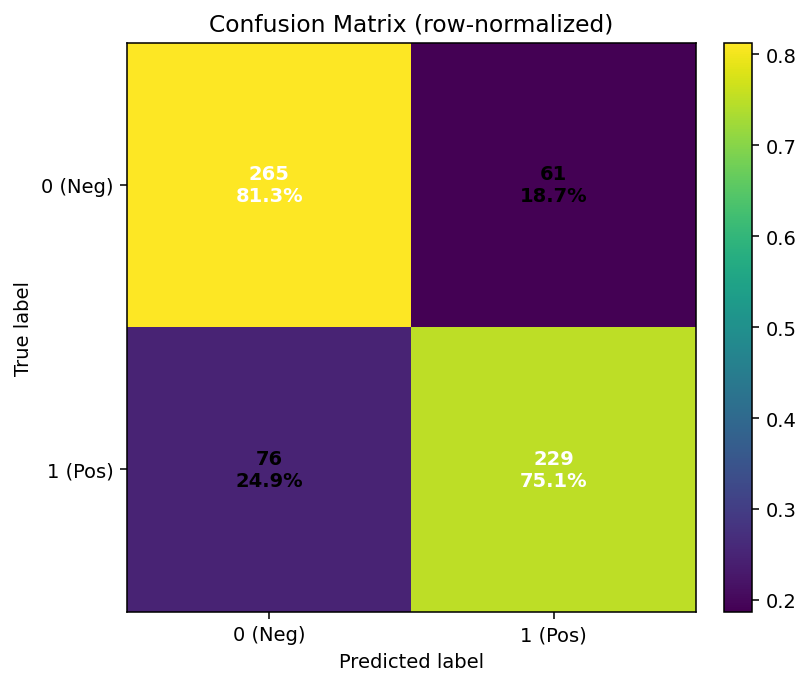

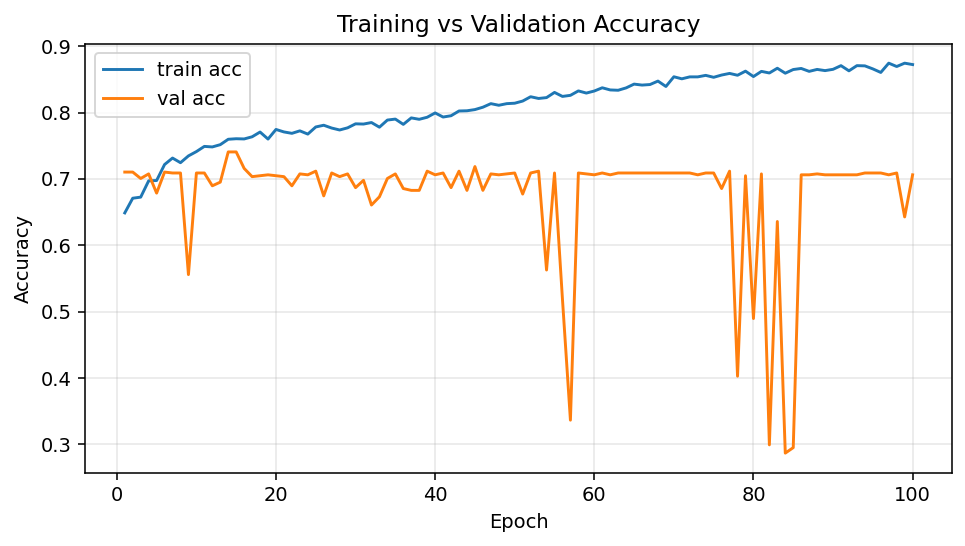

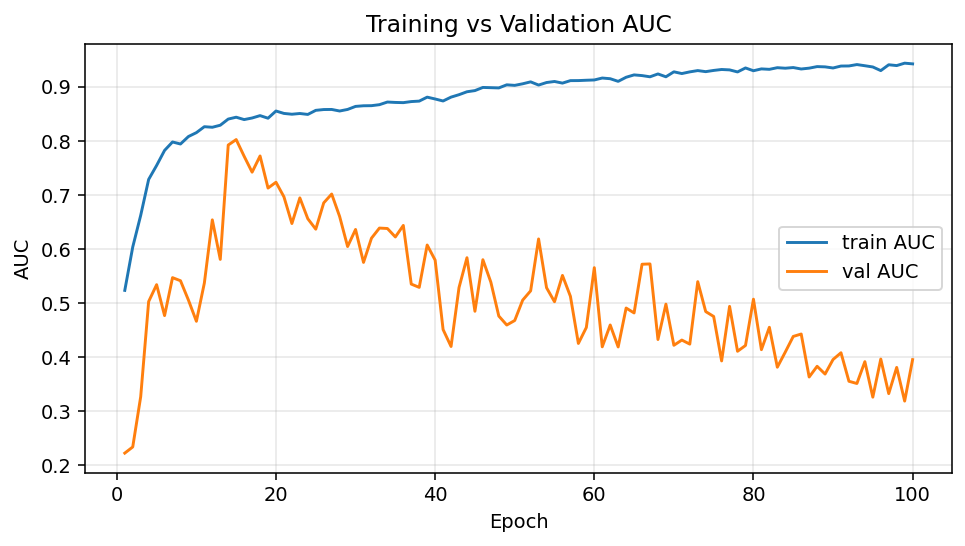

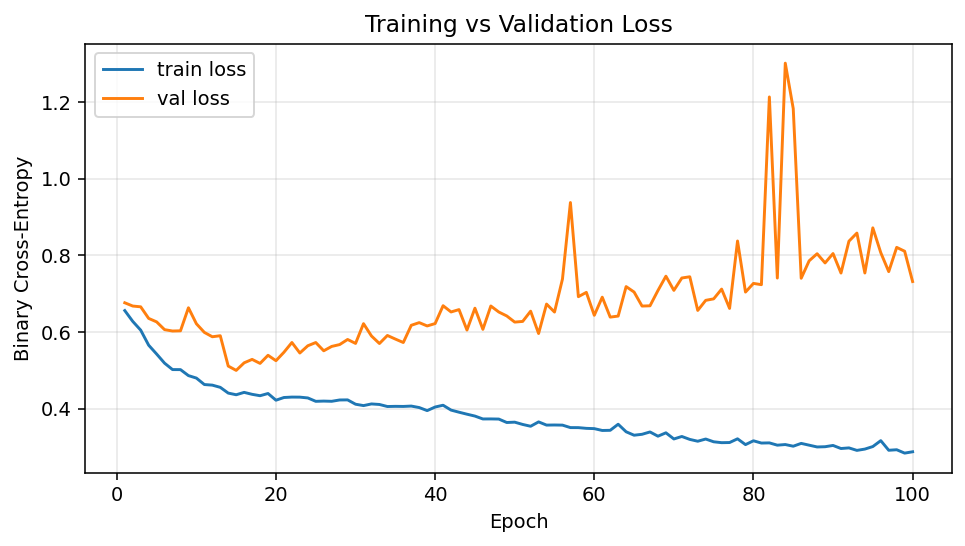

In [ ]:
# === Pretty confusion matrix + training curves ===
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# ----- Confusion matrix (counts + percentages) -----
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

labels = ["0 (Neg)", "1 (Pos)"]
fig_cm, ax = plt.subplots(figsize=(6, 5), dpi=140)
im = ax.imshow(cm_norm, interpolation="nearest")
ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# ticks & labels
ax.set(
    xticks=np.arange(len(labels)),
    yticks=np.arange(len(labels)),
    xticklabels=labels,
    yticklabels=labels,
    xlabel="Predicted label",
    ylabel="True label",
    title="Confusion Matrix (row-normalized)"
)

plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

# annotate each cell with "count\nxx.x%"
thresh = cm_norm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i,
            f"{cm[i, j]}\n{cm_norm[i, j]*100:.1f}%",
            ha="center", va="center",
            color="white" if cm_norm[i, j] > thresh else "black",
            fontsize=10, fontweight="bold"
        )

fig_cm.tight_layout()
plt.show()

# Optionally save:
# fig_cm.savefig("confusion_matrix_pretty.png", bbox_inches="tight", dpi=200)

# ----- Keras history plots: acc, AUC, loss -----
hist = history.history
epochs = np.arange(1, len(hist.get("loss", [])) + 1)

# Some codebases use different metric keys; handle both.
acc_key     = "acc"     if "acc"     in hist else "accuracy"
val_acc_key = "val_acc" if "val_acc" in hist else "val_accuracy"
auc_key     = "auc"
val_auc_key = "val_auc"

# 1) Accuracy
fig1, ax1 = plt.subplots(figsize=(7, 4), dpi=140)
ax1.plot(epochs, hist[acc_key],     label="train acc")
ax1.plot(epochs, hist[val_acc_key], label="val acc")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title("Training vs Validation Accuracy")
ax1.grid(True, alpha=0.3)
ax1.legend()
fig1.tight_layout()
plt.show()
# fig1.savefig("history_accuracy.png", bbox_inches="tight", dpi=200)

# 2) AUC (if present)
if auc_key in hist and val_auc_key in hist:
    fig2, ax2 = plt.subplots(figsize=(7, 4), dpi=140)
    ax2.plot(epochs, hist[auc_key],     label="train AUC")
    ax2.plot(epochs, hist[val_auc_key], label="val AUC")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("AUC")
    ax2.set_title("Training vs Validation AUC")
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    fig2.tight_layout()
    plt.show()
    # fig2.savefig("history_auc.png", bbox_inches="tight", dpi=200)

# 3) Loss
if "loss" in hist and "val_loss" in hist:
    fig3, ax3 = plt.subplots(figsize=(7, 4), dpi=140)
    ax3.plot(epochs, hist["loss"],     label="train loss")
    ax3.plot(epochs, hist["val_loss"], label="val loss")
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("Binary Cross-Entropy")
    ax3.set_title("Training vs Validation Loss")
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    fig3.tight_layout()
    plt.show()

In [ ]:
# --- Dataset sizes + class counts ---
def split_summary(name, files):
    n = len(files)
    ys = np.array([label_for_file(p) for p in files], dtype=int)
    n_pos = int((ys == 1).sum())
    n_neg = int((ys == 0).sum())
    print(f"{name:>6} size: {n:5d}  |  pos: {n_pos:4d}  neg: {n_neg:4d}  "
          f"|  pos%: {100.0 * n_pos / max(1, n):5.1f}")

print("\n--- Split summary ---")
split_summary("train", train_files)
split_summary("val",   val_files)
split_summary("test",  test_files)
print("---------------------\n")


--- Split summary ---
 train size:  6148  |  pos: 2169  neg: 3979  |  pos%:  35.3
   val size:   725  |  pos:  210  neg:  515  |  pos%:  29.0
  test size:   631  |  pos:  305  neg:  326  |  pos%:  48.3
---------------------



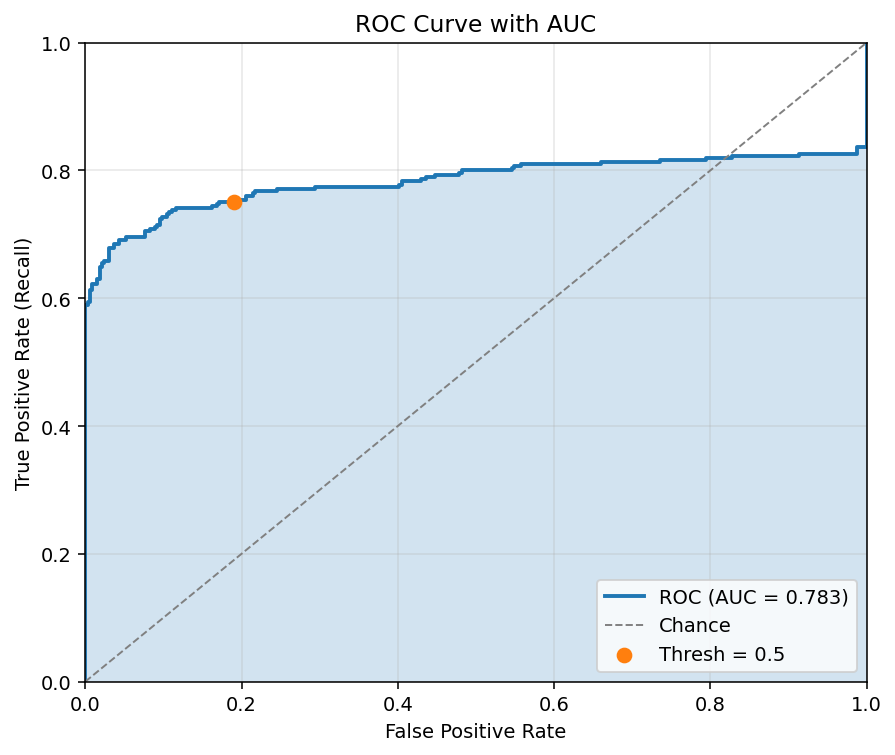

In [ ]:
# --- ROC curve with shaded AUC and the 0.5-threshold operating point ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC
fpr, tpr, thr = roc_curve(y_true, probs1)
roc_auc = roc_auc_score(y_true, probs1)

# Find the point closest to threshold = 0.5 (for marking current operating point)
idx_05 = np.argmin(np.abs(thr - 0.5)) if len(thr) else None

plt.figure(figsize=(6.5, 5.5), dpi=140)
plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC = {roc_auc:.3f})")
plt.fill_between(fpr, tpr, step="pre", alpha=0.2)

# Chance line
plt.plot([0, 1], [0, 1], linestyle="--", lw=1, color="gray", label="Chance")

# Mark operating point at threshold 0.5
if idx_05 is not None and 0 <= idx_05 < len(fpr):
    plt.scatter([fpr[idx_05]], [tpr[idx_05]], s=50, zorder=3, label="Thresh = 0.5")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve with AUC")
plt.grid(alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

AUC = 0.783285
Youden best threshold    : 0.512253463
Min distance ROC threshold: 0.505322278
Best-F1 threshold         : 0.512253463

Using threshold = 0.512253463
Confusion matrix:
 [[312  14]
 [ 94 211]]

Classification report:
               precision    recall  f1-score   support

           0      0.768     0.957     0.852       326
           1      0.938     0.692     0.796       305

    accuracy                          0.829       631
   macro avg      0.853     0.824     0.824       631
weighted avg      0.850     0.829     0.825       631

Accuracy: 0.8288431061806656
F1 score: 0.7962264150943397


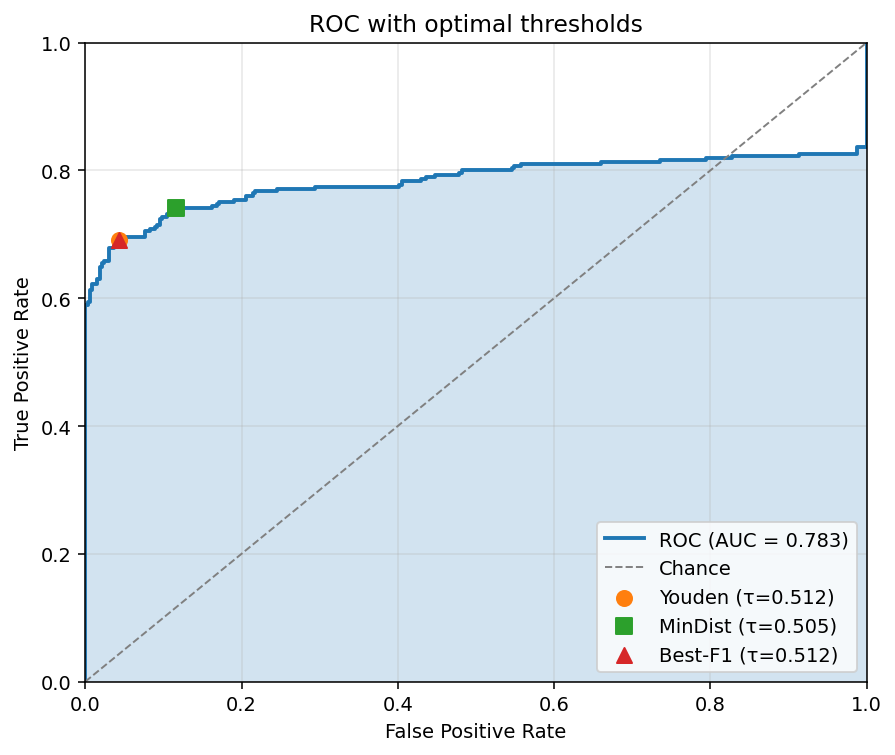

In [ ]:
import numpy as np
from sklearn.metrics import (
    roc_curve, roc_auc_score, precision_recall_curve, f1_score,
    confusion_matrix, classification_report, accuracy_score
)

# --- ROC-based stats ---
fpr, tpr, thr = roc_curve(y_true, probs1)
roc_auc = roc_auc_score(y_true, probs1)

# thresholds can include +inf; ignore it for picking cutpoints
mask = ~np.isinf(thr)
fpr_m, tpr_m, thr_m = fpr[mask], tpr[mask], thr[mask]

# 1) Youden's J (sensitivity + specificity - 1) -> maximize (tpr - fpr)
youden_idx = np.argmax(tpr_m - fpr_m)
thr_youden = float(thr_m[youden_idx])

# 2) Minimum distance to (0,1) on ROC
dist = np.sqrt((1.0 - tpr_m)**2 + (fpr_m**2))
minD_idx = np.argmin(dist)
thr_minD = float(thr_m[minD_idx])

# 3) Best F1 via precision-recall curve thresholds
prec, rec, thr_pr = precision_recall_curve(y_true, probs1)
# thr_pr has length len(prec)-1; compute F1 for those points
f1_vals = 2 * prec[:-1] * rec[:-1] / np.clip(prec[:-1] + rec[:-1], 1e-12, None)
f1_idx = np.argmax(f1_vals)
thr_f1 = float(thr_pr[f1_idx])

print(f"AUC = {roc_auc:.6f}")
print(f"Youden best threshold    : {thr_youden:.9f}")
print(f"Min distance ROC threshold: {thr_minD:.9f}")
print(f"Best-F1 threshold         : {thr_f1:.9f}")

# --- Pick which to use (choose one) ---
thr_best = thr_youden   # or thr_minD, or thr_f1

# Apply threshold and report metrics
y_pred_best = (probs1 >= thr_best).astype(int)

print(f"\nUsing threshold = {thr_best:.9f}")
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred_best))
print("\nClassification report:\n", classification_report(y_true, y_pred_best, digits=3))
print("Accuracy:", accuracy_score(y_true, y_pred_best))
print("F1 score:", f1_score(y_true, y_pred_best))

# (Optional) mark these points on your ROC plot
import matplotlib.pyplot as plt
plt.figure(figsize=(6.5, 5.5), dpi=140)
plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC = {roc_auc:.3f})")
plt.fill_between(fpr, tpr, step="pre", alpha=0.2)
plt.plot([0,1],[0,1],'--',lw=1,color='gray',label='Chance')

# mark Youden
yfpr, ytpr = fpr_m[youden_idx], tpr_m[youden_idx]
plt.scatter([yfpr],[ytpr], s=60, label=f"Youden (τ={thr_youden:.3f})", zorder=3)

# mark min distance
dfpr, dtpr = fpr_m[minD_idx], tpr_m[minD_idx]
plt.scatter([dfpr],[dtpr], s=60, marker='s', label=f"MinDist (τ={thr_minD:.3f})", zorder=3)

nearest = np.argmin(np.abs(thr_m - thr_f1))
ffpr, ftpr = fpr_m[nearest], tpr_m[nearest]
plt.scatter([ffpr],[ftpr], s=60, marker='^', label=f"Best-F1 (τ={thr_f1:.3f})", zorder=3)

plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC with optimal thresholds")
plt.grid(alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()